In [1]:
import numpy as np
from itertools import product
from skimage import draw, transform

# The circle function computes the pixel coordinates of a circle's perimeter centered in an array of given size,
# ...optionally with a reduced radius.
def circle(size, val=None, r_shrink=0):
  circle = np.zeros([size[0] + 1, size[1] + 1])
  rr, cc = draw.circle_perimeter(
      size[0]//2, size[1]//2,
      radius = size[0]//2 - r_shrink,
      shape = [size[0] + 1, size[1] + 1]
  )

  if val is None:
    circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
  else:
    circle[rr, cc] = val
  circle = transform.resize(circle, size, order=0)
  return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
  # Format kernel
  kernel = np.array(kernel)
  if digits is not None:
    kernel = kernel.round(digits)

  # Plot kernel
  cmap = plt.get_cmap('Blues_r')
  plt.imshow(kernel, cmap=cmap)
  rows, cols = kernel.shape
  thresh = (kernel.max() + kernel.min())/2
  ####
  if label:
    for i, j in product(range(rows), range(cols)):
      val = kernel[i, j]
      color = cmap(0) if val > thresh else cmap(255)
      plt.text(j, i, val,
               color=color, size=text_size,
               horizontalalignment='center', verticalalignment='center')

  plt.xticks([])
  plt.yticks([])

def show_extraction(image, kernel, conv_stride=1, conv_padding='valid',
                      activation='relu', pool_size=2, pool_stride=2,
                      pool_padding='same', figsize=(10, 10), subplot_shape=(2, 2),
                      ops=['Input', 'Filter', 'Detect', 'Condense'], gamma=1.0):

  # Create layers
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          filters=1,
          kernel_size=kernel.shape,
          strides=conv_stride,
          padding=conv_padding,
          use_bias=False,
          input_shape=image.shape
      ),
      tf.keras.layers.Activation(activation),
      tf.keras.layers.MaxPool2D(
          pool_size=pool_size,
          strides=pool_stride,
          padding=pool_padding
      )
  ])

  layer_filter, layer_detect, layer_condense = model.layers
  kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
  layer_filter.set_weights([kernel])

  # Format for TF
  image = tf.expand_dims(image, axis=0)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  # Extract features
  image_filter = layer_filter(image)
  image_detect = layer_detect(image_filter)
  image_condense = layer_condense(image_detect)

  # This snippet selectively adds image variants and their brightness/scaling values
  # ...to a dictionary based on requested operations.
  images = {}
  if 'Input' in ops:
    images.update({'Input': (image, 1.0)})
  if 'Filter' in ops:
    images.update({'Filter': (image_filter, 1.0)})
  if 'Detect' in ops:
    images.update({'Detect': (image_detect, gamma)})
  if 'Condense' in ops:
    images.update({'Condense': (image_condense, gamma)})

  # Plot
  plt.figure(figsize=figsize)
  for i, title in enumerate(ops):
    image, gamma = images[title]
    plt.subplot(*subplot_shape, i+1)
    plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
    plt.axis('off')
    plt.title(title)



In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image = tf.io.read_file("/content/car_illus.jpg")
image = tf.io.decode_jpeg(image)

## Introduction

In [4]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=1, padding='same')
])

## Exploring Sliding Windows

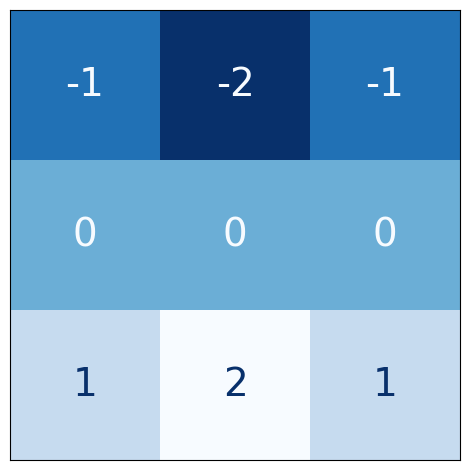

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image=tf.reshape(image, [*image.shape, 1])
kernel = tf.constant([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1],
])
show_kernel(kernel)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


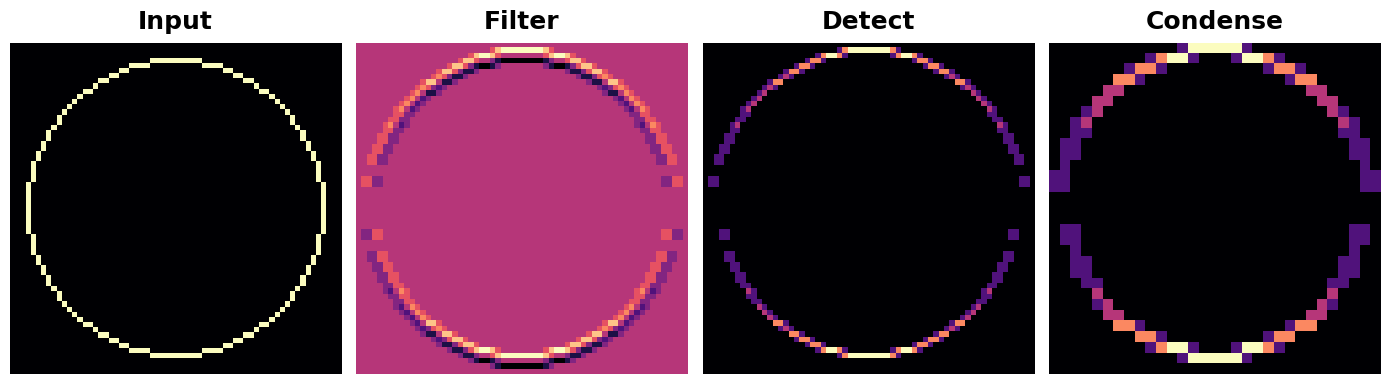

In [6]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,
    subplot_shape=(1, 4),
    figsize=(14, 6)
)

# WITH conv_stride=3

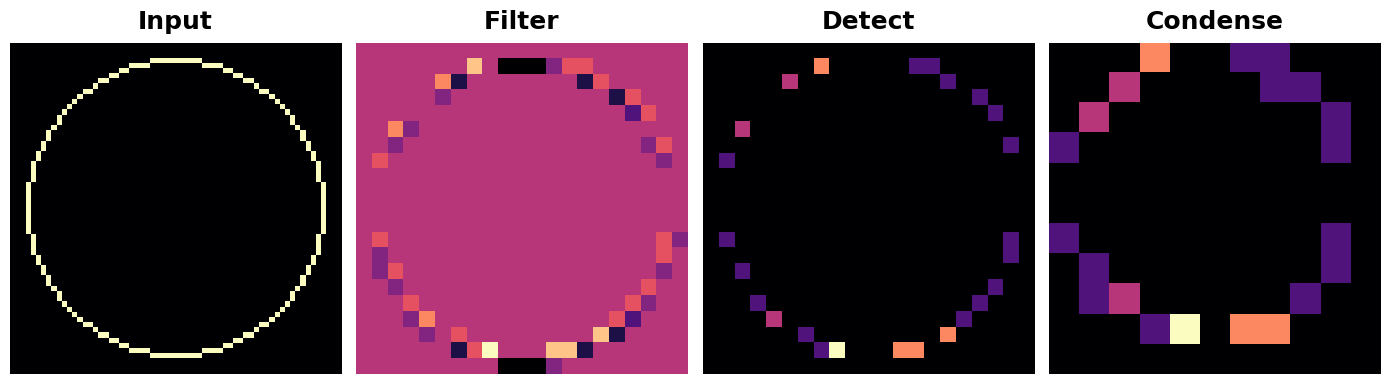

In [7]:
show_extraction(
    image, kernel,
    conv_stride=3,
    pool_size=2,
    pool_stride=2,
    subplot_shape=(1, 4),
    figsize=(14, 6)
)